In [1]:
import sys
lib = r'D:\Technion studies\Keren Laboratory\python_playground\classifying-response-to-immunotherapy\utilities\droplet_dataset'
lib2 = r'D:\Technion studies\Keren Laboratory\python_playground\classifying-response-to-immunotherapy\utilities'
lib3 = r'D:\Technion studies\Keren Laboratory\python_playground\classifying-response-to-immunotherapy\data_analysis'
lib4 = r'D:\Technion studies\Keren Laboratory\python_playground\classifying-response-to-immunotherapy'
sys.path.append(lib)
sys.path.append(lib2)
sys.path.append(lib3)
sys.path.append(lib4)
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
import numpy as np
import matplotlib
from utilities.droplet_dataset import  build_cohort
import os
from os.path import join
from DL.Mars_seq_DL.data_loading import *
from utilities.droplet_dataset import *
import math
import matplotlib as plt
from sklearn.manifold import TSNE
import statsmodels as sm
import scipy.stats as stats
from Bio.Cluster import kcluster
from sklearn.manifold import TSNE
import pickle
from scipy.stats import pearsonr
import statsmodels as sm


# %matplotlib notebook

In [2]:
######## LOADING DATA ########
sample_id = 'M104'
ROW_SAMPLES_PATH = fr'D:\Technion studies\Keren Laboratory\Data\droplet_seq\ROW_DATA'
SAMPLES_INFORMATION_PATH = fr'D:\Technion studies\Keren Laboratory\python_playground\outputs\inferCNV\update_runs\4.3.21'


rna_sample = loading_sample(row_data_path=join(ROW_SAMPLES_PATH, f'{sample_id}.pkl'),
                                cells_information_path=join(SAMPLES_INFORMATION_PATH, f'{sample_id}.pkl'))


In [3]:
######## CLEAN & NORMALIZE DATA ########
VARIANCE = 3
rna_sample = rna_sample.filter_cells_by_property("should_be_removed", False)
rna_sample.normalize_data()
sample = rna_sample.filter_genes_by_variance(VARIANCE, in_place=True).counts
print(f'Sample size after filtering variance: {sample.shape}')

Dataset was cleared from genes with variance of less than 3
Sample size after filtering variance: (4162, 49)


In [4]:
######## TSNE ########
cells_embedded = TSNE(n_components=2, random_state=21).fit_transform(sample)

In [5]:
######## KMEANS ########

# user_function = lambda point1, point2: abs(point1[0] - point2[0]) # Manhattan
# user_function = lambda point1, point2: pearsonr(point1, point2) # pearson
def user_function(point1, point2):
#     return abs(point1[0] - point2[0])
    return 1 - pearsonr(point1, point2)[0]


metric = distance_metric(type_metric.USER_DEFINED, func=user_function)

# create K-Means algorithm with specific distance metric
initial_centers = kmeans_plusplus_initializer(sample, 4).initialize()

kmeans_instance = kmeans(sample, initial_centers, metric=metric)

# run cluster analysis and obtain results
kmeans_instance.process()
clusters = kmeans_instance.get_clusters()

# Set colors with clusters
cluster_colors = np.zeros(sample.shape[0])
for cluster_idx, cluster_list in enumerate(kmeans_instance.get_clusters()):
    cluster_colors[cluster_list] = cluster_idx

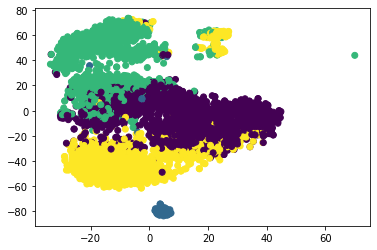

In [6]:
######## PLOT ########
plot_colors = rna_sample.cells_information.getattr('is_cancer')
# plot_colors = cluster_colors

plt.pyplot.scatter(cells_embedded[:,0], cells_embedded[:,1], c=cluster_colors)

In [7]:
# dict(rna_sample.get_statistics()['immune cell types'])

In [8]:
centers = kmeans_instance.get_centers()
np.array(centers).shape

(4, 49)

In [9]:
#### KMEANS details #####

def distance_metric(p1, p2):
    return 1 - pearsonr(p1, p2)[0]


print('cluster sizes')
print([len(kmeans_instance.get_clusters()[ii]) for ii in range(len(kmeans_instance.get_clusters()))], end="\n\n")

######## Calculate kmeans distances

centers = np.array(list(kmeans_instance.get_centers()))
n_clusters = centers.shape[0]

clusters_distances = [[] for _ in range(n_clusters)]


for cluster_idx, cluster in enumerate(clusters):
    cluster_cells = sample[cluster]
    for cell in cluster_cells:
        clusters_distances[cluster_idx].append(distance_metric(cell, centers[cluster_idx]))



for distances in clusters_distances:
    print(np.mean(distances))


cluster sizes
[1650, 86, 1290, 1136]

0.22094445847668887
0.2020022507914619
0.33627402911120396
0.24737563609457836


In [10]:
#### KMEANS details #####

# def distance_metric(p1, p2):
#     return 1 - pearsonr(p1, p2)[0]

# ######## Calculate kmeans distances

# centers = np.array(kmeans_instance.get_centers())



# cluster0_distances = [[], []]
# for cell_idx in range(len(sample[clusters[0]])):
#     cluster0_distances[0].append(distance_metric(sample[clusters[0]][cell_idx], c0))
#     cluster0_distances[1].append(distance_metric(sample[clusters[0]][cell_idx], c1))

# cluster1_distances = [[], []]
# for cell_idx in range(len(sample[clusters[1]])):
#     cluster1_distances[0].append(1 - pearsonr(sample[clusters[1]][cell_idx], c0)[0])
#     cluster1_distances[1].append(1 - pearsonr(sample[clusters[1]][cell_idx], c1)[0])
    

# cluster0_distances[0] = np.mean(cluster0_distances[0])
# cluster0_distances[1] = np.mean(cluster0_distances[1])

# cluster1_distances[0] = np.mean(cluster1_distances[0])
# cluster1_distances[1] = np.mean(cluster1_distances[1])

# print("2 first clusters distsances")
# print(cluster0_distances)
# print(cluster1_distances)

In [14]:
sample_clusters = [rna_sample[kmeans_instance.get_clusters()[ii]] for ii in range(len(kmeans_instance.get_clusters()))]

In [15]:


cluster_mapping = np.zeros(sample.shape[0])
for cluster_idx, cluster_list in enumerate(kmeans_instance.get_clusters()):
    print(cluster_idx)
    cluster_mapping[cluster_list] = cluster_idx
# kmeans_instance.get_clusters()
cluster_mapping
Counter(cluster_mapping)

0
1
2
3


Counter({2.0: 1290, 0.0: 1650, 3.0: 1136, 1.0: 86})

In [16]:
percentage_voting_expression_in_clusters = []
p_values = []  # before correction
cluster = 1
cluster_indices = [idx for idx, val in enumerate(cluster_mapping) if val == cluster]
other_clusters_indices = [idx for idx, val in enumerate(cluster_mapping) if val != cluster]


In [17]:

cluster_data = rna_sample[cluster_indices]
other_clusters_data = rna_sample[other_clusters_indices]

In [18]:
for gene_idx in range(cluster_data.number_of_genes):
    if not gene_idx%10:
        print(f'{gene_idx+1}/{cluster_data.number_of_genes}')
    cluster_gene_expression = cluster_data.counts[:, gene_idx] > 1
    other_clusters_gene_expression = other_clusters_data.counts[:, gene_idx] > 1

    number_of_cells_expressing_gene_in_cluster = sum(cluster_gene_expression)
    number_of_cells_expressing_gene_in_other_clusters = sum(other_clusters_gene_expression)

    n_cells_in_cluster = len(cluster_gene_expression)
    n_cells_in_other_clusters = len(other_clusters_gene_expression)

    oddsratio, pvalue = stats.fisher_exact([[number_of_cells_expressing_gene_in_cluster,
                                             number_of_cells_expressing_gene_in_other_clusters],
                                            [n_cells_in_cluster, n_cells_in_other_clusters]])

    p_voting_expression_in_cluster = number_of_cells_expressing_gene_in_cluster / n_cells_in_cluster

#     percentage_voting_expression_in_clusters.append(p_voting_expression_in_cluster)
    percentage_voting_expression_in_clusters.append([[number_of_cells_expressing_gene_in_cluster, number_of_cells_expressing_gene_in_other_clusters],
                                                     [n_cells_in_cluster, n_cells_in_other_clusters]])
    p_values.append(pvalue)
print("Done")

1/49
11/49
21/49
31/49
41/49
Done


In [19]:

arr_gene_names = np.array(cluster_data.gene_names)
arr_p_values = np.array(p_values)
order = np.argsort(arr_p_values)

arr_ratio = np.array(percentage_voting_expression_in_clusters)





for idx in range(10):
#     idx = 3
    print('------------------------------')
    print(f'P_val location: {idx}')
    print(f'gene name \t\t{arr_gene_names[order[idx]]}')
    print(f'p val \t\t{arr_p_values[order[idx]]}')
    print(f'\nvalues\n{arr_ratio[order[idx]]}')
    print(f'\nRatio\n{arr_ratio[order[idx]][0] / arr_ratio[order[idx]][1]}')

# len(p_values)

------------------------------
P_val location: 0
gene name 		HBB
p val 		4.982711494212483e-100

values
[[  86   38]
 [  86 4076]]

Ratio
[1.         0.00932287]
------------------------------
P_val location: 1
gene name 		MALAT1
p val 		3.966468395223335e-12

values
[[  10 3123]
 [  86 4076]]

Ratio
[0.11627907 0.76619235]
------------------------------
P_val location: 2
gene name 		S100A10
p val 		5.3482879056202456e-12

values
[[   9 2952]
 [  86 4076]]

Ratio
[0.10465116 0.72423945]
------------------------------
P_val location: 3
gene name 		SPARC
p val 		9.97205669086981e-12

values
[[  12 3275]
 [  86 4076]]

Ratio
[0.13953488 0.80348381]
------------------------------
P_val location: 4
gene name 		CST3
p val 		1.4757804521095208e-11

values
[[  13 3361]
 [  86 4076]]

Ratio
[0.15116279 0.82458292]
------------------------------
P_val location: 5
gene name 		EEF1B2
p val 		1.8688251500708358e-11

values
[[  12 3233]
 [  86 4076]]

Ratio
[0.13953488 0.79317959]
------------------

In [92]:
np.log2(np.mean(cluster_data.counts, axis=0)/np.mean(other_clusters_data.counts, axis=0))

array([-0.81380535, -0.29562223, -0.38409786, -0.55414291, -0.12562579,
       -0.66216972,  0.74548464,  0.25317044,  0.18890702, -1.22453114,
       -0.67752086,  0.3483582 , -0.5557649 ,  0.36093588, -0.26233263,
       -0.48703083, -0.23985806,  0.66612559, -0.43799182, -0.00770475,
        1.16684145, -2.71240439, -0.03895333, -0.67630842, -0.6351925 ,
       -0.42539295, -0.35493195,  0.06127102, -0.52440249, -3.86759382,
        0.32494901, -0.46493331,  0.60238529, -0.92293932, -0.61396542,
        0.11885365, -0.22486816,  0.2574869 ,  0.17447513,  0.08971929,
       -0.18820689, -0.36192083, -0.94174547, -0.04982827, -0.08923152,
       -0.32687   ,  0.9797796 ,  0.52202984,  0.76553937])

In [88]:
np.mean(cluster_data.counts[:, order], axis=0)

array([0.23053819, 2.75586794, 3.02765547, 3.95219769, 3.89380687,
       5.7278921 , 3.10405823, 1.78480408, 0.02683387, 1.93835458,
       0.61353806, 3.82182034, 4.19077754, 2.11704018, 2.45860091,
       5.36606561, 3.09251305, 5.42647175, 2.31351413, 1.5887265 ,
       2.38698037, 3.19538892, 5.37664674, 2.43808213, 3.73722435,
       1.72394209, 4.53029025, 5.93710537, 4.24196374, 2.61752482,
       2.75646815, 2.08081697, 2.16793984, 3.79668527, 3.3397572 ,
       3.7081355 , 2.91027365, 3.68848953, 3.29186438, 2.11501222,
       6.84192075, 3.64703424, 3.34848363, 3.26542711, 3.94183903,
       3.50613281, 2.46893542, 3.79769189, 3.84950161])

In [45]:
np.log2((arr_ratio[order][:,0] / arr_ratio[order][:,1]))

array([[-3.49416484, -1.63957302],
       [-0.63055331, -1.55702949],
       [-0.28190038, -1.00423699],
       [-0.18718709, -0.82532972],
       [-0.16038703, -0.71395909],
       [-0.07587751, -0.55012993],
       [-0.28511351, -0.72790576],
       [-0.6699114 , -1.02800516],
       [-6.28672276, -4.80219322],
       [-0.52802365, -0.22435245],
       [-1.82729114, -1.44784364],
       [-0.12541089, -0.37166464],
       [-0.17372483, -0.40488808],
       [-0.42874177, -0.21996568],
       [-0.40582738, -0.61704748],
       [-0.0306826 , -0.22490173],
       [-0.23144033, -0.42431228],
       [-0.03203155, -0.20905678],
       [-0.36615723, -0.19230934],
       [-0.73872659, -0.56674464],
       [-0.34756336, -0.50606957],
       [-0.28511351, -0.4319021 ],
       [-0.01059836, -0.13957339],
       [-0.33086532, -0.45878539],
       [-0.14425097, -0.254878  ],
       [-0.67201292, -0.78346194],
       [-0.1210979 , -0.21450092],
       [-0.00661484, -0.08969748],
       [-0.10255584,

In [20]:
sm.stats.multitest.multipletests

AttributeError: module 'statsmodels' has no attribute 'stats'

In [69]:
# np.array(np.round(percentage_voting_expression_in_clusters, 3))[np.argsort(np.array(p_values))][:20]

In [ ]:
rna_sample.normalize_data()
Counter(np.round(np.ndarray.flatten(rna_sample.counts[:2][:100])))

In [ ]:
# rna_sample.counts.shape
plt.pyplot.boxplot(np.ndarray.flatten(rna_sample.counts[:2][:100]))

In [ ]:
np.argsort(np.array(p_values)

In [120]:
sample.shape

(4162, 49)

In [88]:
import umap

In [89]:
embedding = umap.UMAP().fit_transform(sample)

<IPython.core.display.Javascript object>


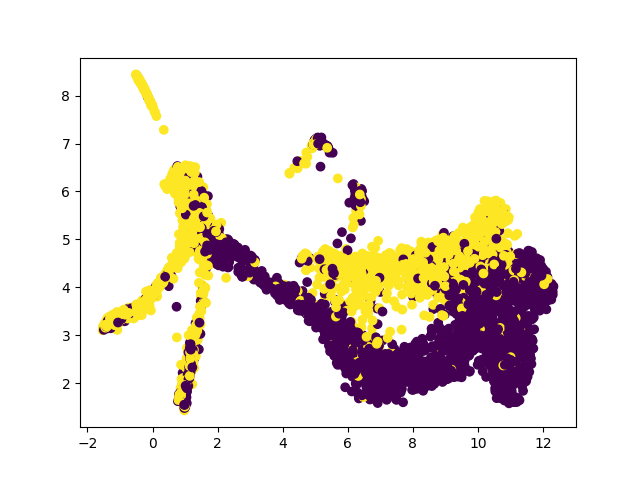

In [95]:
plt.pyplot.scatter(embedding[:,0], embedding[:,1], c=filtered_rna.cells_information.getattr('is_stromal'))

In [22]:
def _fdr(p_vals):

    from scipy.stats import rankdata
    ranked_p_values = rankdata(p_vals)
    fdr = p_vals * len(p_vals) / ranked_p_values
    fdr[fdr > 1] = 1
    return fdr

In [27]:
ppp = np.array([0.01, 0.02, 0.04, 0.15])
print(_fdr(ppp))
ppp = np.array([0.01, 0.04, 0.15, 0.02])
print(_fdr(ppp))

[0.04       0.04       0.05333333 0.15      ]
[0.04       0.05333333 0.15       0.04      ]


In [32]:
import scipy.stats as stats

oddsratio, pvalue = stats.fisher_exact([[2,8],
                                        [10, 4]], alternative='two-sided')
pvalue

0.036074841836047825

In [34]:
import scipy

In [72]:
a = np.array([[1, 2, 3], [100, 101, 102], [50, 51, 52]])
print(scipy.stats.zscore(a, axis=0))
# (a - np.mean(a))/ np.var(a, ddof=1)

np.sum(a, axis=1)

[[-1.2206004 -1.2206004 -1.2206004]
 [ 1.2288477  1.2288477  1.2288477]
 [-0.0082473 -0.0082473 -0.0082473]]


array([  6, 303, 153])